# Prediction of Students' Dropout and Academic Success - Classification with Dimensionality Reduction
Neil John Catapang

## Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from time import time

## Reading the Dataset + EDA + Cleaning

In [2]:
student_df = pd.read_csv("data.csv", sep=';')
pd.options.display.max_columns = None

display(student_df)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,5,4,122.2,0,0,0,1,1,0,19,0,0,6,7,5,13.600000,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,9,9,119.0,1,0,1,0,0,0,18,1,0,6,6,6,12.000000,0,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,9,9,149.5,1,0,0,1,0,1,30,0,0,7,8,7,14.912500,0,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,7,4,153.8,1,0,0,1,0,1,20,0,0,5,5,5,13.800000,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


The dataset is composed of 36 features, and one column of target labels which indicate academic success of each example (student).

In [3]:
print("Dataset information:")
print(student_df.info(), "\n")

print(f"Dataset Summary: \n{student_df.describe(include="all")}")

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualificati

No missing data. All are numeric data (some features are categorical (encoded), while some are continuous or ordinal).

In [4]:
# Encode labels for inclusion in heatmap
target_map = {'Dropout': 0, 'Enrolled': 1, "Graduate": 2}
target_encoded = student_df['Target'].map(target_map)
student_df_encoded = pd.concat([student_df.drop(columns=['Target']), target_encoded], axis=1)

Heatmap of features (including the target) were plotted below to see if there are highly-correlated features, as well as features that show correlation with the target label (possible important features).

c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


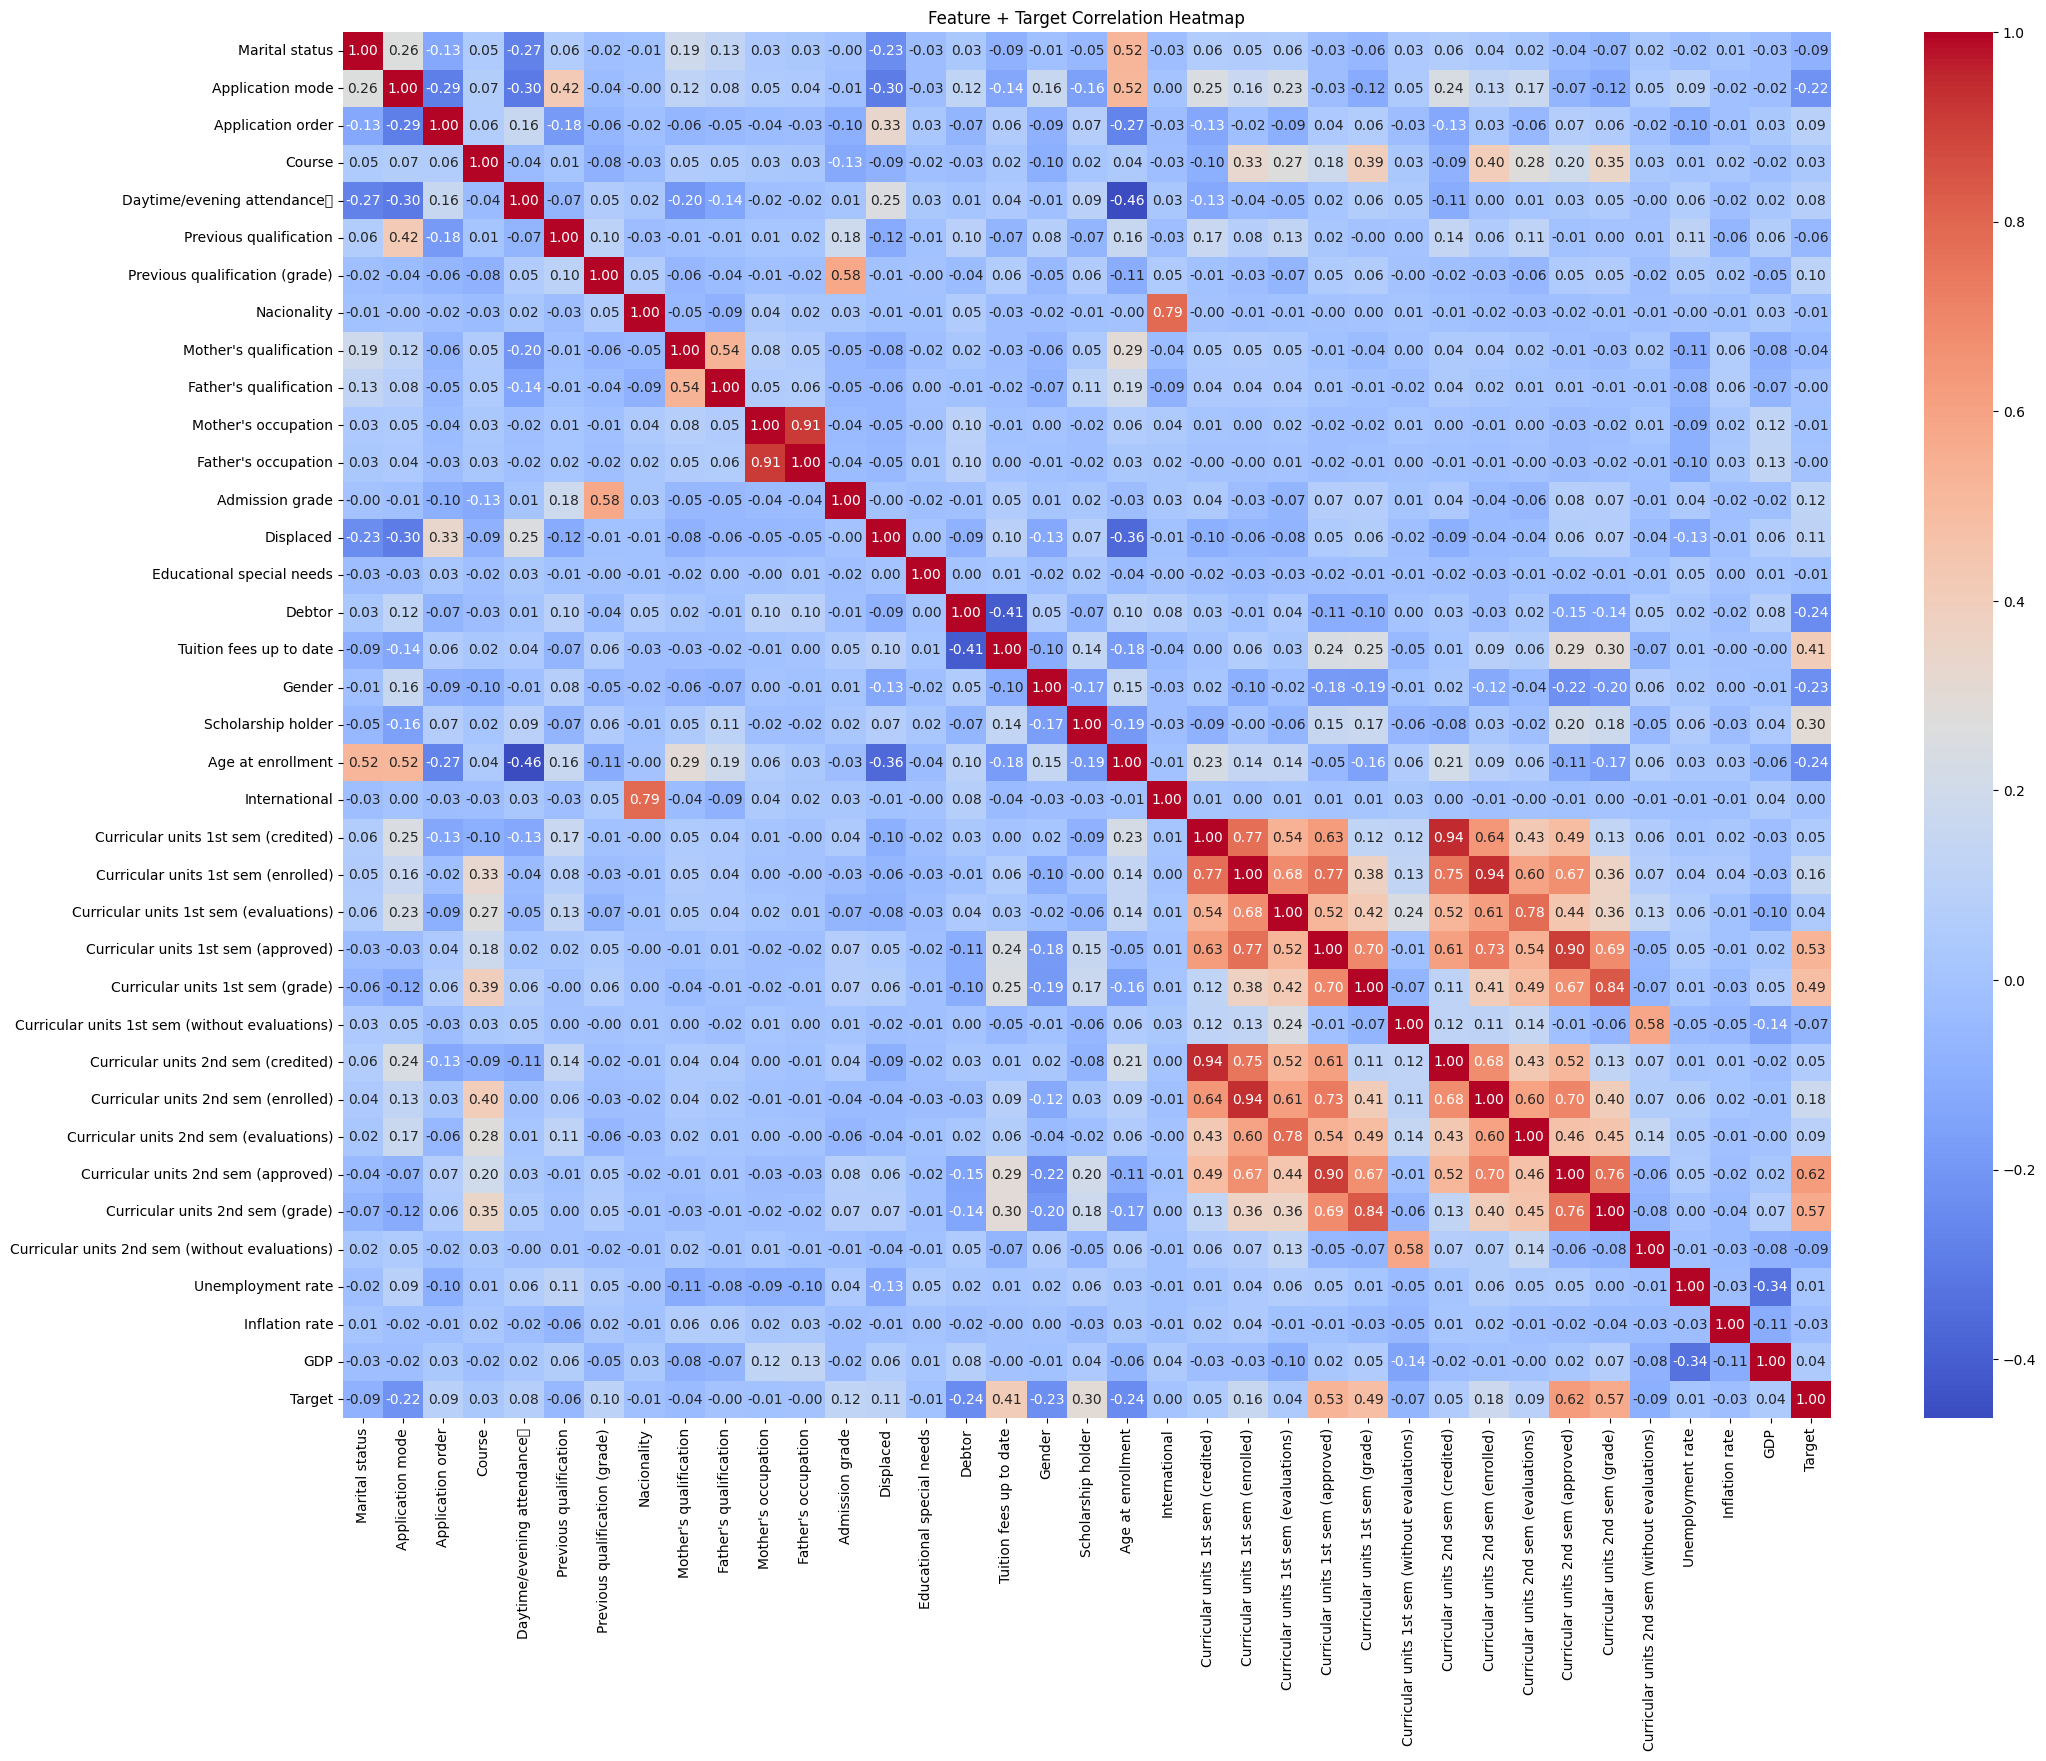

In [5]:
corr_matrix = student_df_encoded.corr()

plt.figure(figsize=(24, 18))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature + Target Correlation Heatmap")
plt.show()

There is high correlation observed from a few pair of features (>= 0.90), including:
1. Curricular units 1st sem (credited) vs. Curricular units 2nd sem (credited): 0.94
2. Curricular units 1st sem (enrolled) vs. Curricular units 2nd sem (enrolled): 0.94
3. Mother's occupation vs. Father's Occupation: 0.91
4. Curricular units 1st sem (approved) vs. Curricular units 2nd sem (approved): 0.90

One in each pair of features were removed (in succeeding parts of this notebook) to improve the performance of the model.


There is moderate correlation between curricular units and the target. This would give us an idea on the importance of these features in predicting the students' status/academic success.

Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64

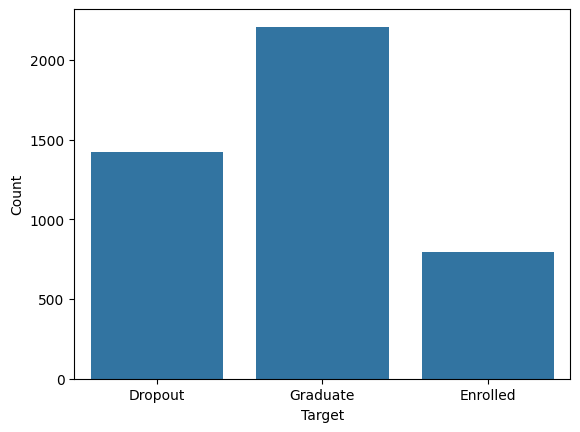

In [6]:
sns.countplot(x='Target', data=student_df)
plt.ylabel('Count')
student_df['Target'].value_counts(normalize=True)

There is noticeable class imbalance in this dataset, favoring the 'Graduate' class. This will be addressed using Synthetic Minority Oversampling Technique.

### Dataset Cleaning (Removing Highly-Correlated Features)

In [7]:
# Index the columns based on their type (categorical or numeric)
categorical_features = [
    0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 
    13, 14, 15, 16, 17, 18, 20
]

numeric_features = [
    6, 12, 19, 23, 25, 26, 27, 28, 
    29, 30, 31, 32, 33, 34, 35
]

removed_features = [
    10, 21, 22, 24
]

X_categorical = student_df_encoded.iloc[:, categorical_features].astype(str)
X_categorical = pd.get_dummies(X_categorical, drop_first=True).astype(int)
X_numeric = student_df_encoded.iloc[:, numeric_features]
y = student_df_encoded.iloc[:, 36]

display(X_categorical)

,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_10,Application mode_15,Application mode_16,Application mode_17,Application mode_18,Application mode_2,Application mode_26,Application mode_27,Application mode_39,Application mode_42,Application mode_43,Application mode_44,Application mode_5,Application mode_51,Application mode_53,Application mode_57,Application mode_7,Application order_1,Application order_2,Application order_3,Application order_4,Application order_5,Application order_6,Application order_9,Course_33,Course_8014,Course_9003,Course_9070,Course_9085,Course_9119,Course_9130,Course_9147,Course_9238,Course_9254,Course_9500,Course_9556,Course_9670,Course_9773,Course_9853,Course_9991,Daytime/evening attendance\t_1,Previous qualification_10,Previous qualification_12,Previous qualification_14,Previous qualification_15,Previous qualification_19,Previous qualification_2,Previous qualification_3,Previous qualification_38,Previous qualification_39,Previous qualification_4,Previous qualification_40,Previous qualification_42,Previous qualification_43,Previous qualification_5,Previous qualification_6,Previous qualification_9,Nacionality_100,Nacionality_101,Nacionality_103,Nacionality_105,Nacionality_108,Nacionality_109,Nacionality_11,Nacionality_13,Nacionality_14,Nacionality_17,Nacionality_2,Nacionality_21,Nacionality_22,Nacionality_24,Nacionality_25,Nacionality_26,Nacionality_32,Nacionality_41,Nacionality_6,Nacionality_62,Mother's qualification_10,Mother's qualification_11,Mother's qualification_12,Mother's qualification_14,Mother's qualification_18,Mother's qualification_19,Mother's qualification_2,Mother's qualification_22,Mother's qualification_26,Mother's qualification_27,Mother's qualification_29,Mother's qualification_3,Mother's qualification_30,Mother's qualification_34,Mother's qualification_35,Mother's qualification_36,Mother's qualification_37,Mother's qualification_38,Mother's qualification_39,Mother's qualification_4,Mother's qualification_40,Mother's qualification_41,Mother's qualification_42,Mother's qualification_43,Mother's qualification_44,Mother's qualification_5,Mother's qualification_6,Mother's qualification_9,Father's qualification_10,Father's qualification_11,Father's qualification_12,Father's qualification_13,Father's qualification_14,Father's qualification_18,Father's qualification_19,Father's qualification_2,Father's qualification_20,Father's qualification_22,Father's qualification_25,Father's qualification_26,Father's qualification_27,Father's qualification_29,Father's qualification_3,Father's qualification_30,Father's qualification_31,Father's qualification_33,Father's qualification_34,Father's qualification_35,Father's qualification_36,Father's qualification_37,Father's qualification_38,Father's qualification_39,Father's qualification_4,Father's qualification_40,Father's qualification_41,Father's qualification_42,Father's qualification_43,Father's qualification_44,Father's qualification_5,Father's qualification_6,Father's qualification_9,Father's occupation_1,Father's occupation_10,Father's occupation_101,Father's occupation_102,Father's occupation_103,Father's occupation_112,Father's occupation_114,Father's occupation_121,Father's occupation_122,Father's occupation_123,Father's occupation_124,Father's occupation_131,Father's occupation_132,Father's occupation_134,Father's occupation_135,Father's occupation_141,Father's occupation_143,Father's occupation_144,Father's occupation_151,Father's occupation_152,Father's occupation_153,Father's occupation_154,Father's occupation_161,Father's occupation_163,Father's occupation_171,Father's occupation_172,Father's occupation_174,Father's occupation_175,Father's occupation_181,Father's occupation_182,Father's occupation_183,Father's occupation_192,Father's occupation_193,Father's occupation_194,Father's occupation_195,Father's occupation_2,Father's occupation_3,Father's occupation_4,Father's occupation_5,Fat

In [8]:
student_df_cleaned = pd.concat([X_categorical, X_numeric, y], axis=1)
display(student_df_cleaned)

,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_10,Application mode_15,Application mode_16,Application mode_17,Application mode_18,Application mode_2,Application mode_26,Application mode_27,Application mode_39,Application mode_42,Application mode_43,Application mode_44,Application mode_5,Application mode_51,Application mode_53,Application mode_57,Application mode_7,Application order_1,Application order_2,Application order_3,Application order_4,Application order_5,Application order_6,Application order_9,Course_33,Course_8014,Course_9003,Course_9070,Course_9085,Course_9119,Course_9130,Course_9147,Course_9238,Course_9254,Course_9500,Course_9556,Course_9670,Course_9773,Course_9853,Course_9991,Daytime/evening attendance\t_1,Previous qualification_10,Previous qualification_12,Previous qualification_14,Previous qualification_15,Previous qualification_19,Previous qualification_2,Previous qualification_3,Previous qualification_38,Previous qualification_39,Previous qualification_4,Previous qualification_40,Previous qualification_42,Previous qualification_43,Previous qualification_5,Previous qualification_6,Previous qualification_9,Nacionality_100,Nacionality_101,Nacionality_103,Nacionality_105,Nacionality_108,Nacionality_109,Nacionality_11,Nacionality_13,Nacionality_14,Nacionality_17,Nacionality_2,Nacionality_21,Nacionality_22,Nacionality_24,Nacionality_25,Nacionality_26,Nacionality_32,Nacionality_41,Nacionality_6,Nacionality_62,Mother's qualification_10,Mother's qualification_11,Mother's qualification_12,Mother's qualification_14,Mother's qualification_18,Mother's qualification_19,Mother's qualification_2,Mother's qualification_22,Mother's qualification_26,Mother's qualification_27,Mother's qualification_29,Mother's qualification_3,Mother's qualification_30,Mother's qualification_34,Mother's qualification_35,Mother's qualification_36,Mother's qualification_37,Mother's qualification_38,Mother's qualification_39,Mother's qualification_4,Mother's qualification_40,Mother's qualification_41,Mother's qualification_42,Mother's qualification_43,Mother's qualification_44,Mother's qualification_5,Mother's qualification_6,Mother's qualification_9,Father's qualification_10,Father's qualification_11,Father's qualification_12,Father's qualification_13,Father's qualification_14,Father's qualification_18,Father's qualification_19,Father's qualification_2,Father's qualification_20,Father's qualification_22,Father's qualification_25,Father's qualification_26,Father's qualification_27,Father's qualification_29,Father's qualification_3,Father's qualification_30,Father's qualification_31,Father's qualification_33,Father's qualification_34,Father's qualification_35,Father's qualification_36,Father's qualification_37,Father's qualification_38,Father's qualification_39,Father's qualification_4,Father's qualification_40,Father's qualification_41,Father's qualification_42,Father's qualification_43,Father's qualification_44,Father's qualification_5,Father's qualification_6,Father's qualification_9,Father's occupation_1,Father's occupation_10,Father's occupation_101,Father's occupation_102,Father's occupation_103,Father's occupation_112,Father's occupation_114,Father's occupation_121,Father's occupation_122,Father's occupation_123,Father's occupation_124,Father's occupation_131,Father's occupation_132,Father's occupation_134,Father's occupation_135,Father's occupation_141,Father's occupation_143,Father's occupation_144,Father's occupation_151,Father's occupation_152,Father's occupation_153,Father's occupation_154,Father's occupation_161,Father's occupation_163,Father's occupation_171,Father's occupation_172,Father's occupation_174,Father's occupation_175,Father's occupation_181,Father's occupation_182,Father's occupation_183,Father's occupation_192,Father's occupation_193,Father's occupation_194,Father's occupation_195,Father's occupation_2,Father's occupation_3,Father's occupation_4,Father's occupation_5,Fat

After removing highly-correlated features, the cleaned dataset now only has 32 features (but resulted in 210 features due to one-hot encoding).

## Creating Models to Predict Students' Status

### Dataset Balancing, Split, and Scaling

In [9]:
# Split the features and target
X = student_df_cleaned.drop(columns=['Target'])
y = student_df_cleaned['Target']

# Oversample the dataset
oversample = SMOTE(random_state=42)
X_over, y_over = oversample.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.30, random_state=42, stratify=y_over)
categ_cols = X.columns[:195]
numeric_cols = X.columns[195:]

# Scale the numeric features
scaler = StandardScaler()
X_train[numeric_cols] = X_train[numeric_cols].astype(float)
X_test[numeric_cols] = X_test[numeric_cols].astype(float)
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])  
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

### Models from Previous Assignment (PCA and LDA)

#### PCA + SVC

To proceed with PCA, I decided to first find the minimum number of principal components that explain 95% of the variance in the numeric features.

The optimal number of PC found which explains at least 95% variance is <code>11</code>. This was used in transforming the numeric feature space to a lower-dimensional space.

In [10]:
# PCA the numeric features with 95% explained variance
pca = PCA(n_components=0.95)
X_train_num_pca = pca.fit_transform(X_train[numeric_cols])
X_test_num_pca = pca.transform(X_test[numeric_cols])

# Merge the feature space
X_train_num_pca = pd.DataFrame(X_train_num_pca, columns=[f'PC{i+1}' for i in range(X_train_num_pca.shape[1])])
X_train_pca = pd.concat([X_train_num_pca.reset_index(drop=True),
                        X_train[categ_cols].reset_index(drop=True)], axis=1)
X_test_num_pca = pd.DataFrame(X_test_num_pca, columns=[f'PC{i+1}' for i in range(X_test_num_pca.shape[1])])
X_test_pca = pd.concat([X_test_num_pca.reset_index(drop=True),
                        X_test[categ_cols].reset_index(drop=True)], axis=1)

print(X_train.shape)
print(X_train_pca.shape)
print(X_test_pca.shape)


(4638, 210)
(4638, 206)
(1989, 206)


The numeric features space were reduced from 15 to 11 dimensions with 95% explained variance.

In [11]:
# The base support vector classifier pipeline
svc = SVC()

# Specify grid of hyperparameters
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["rbf", "poly", "sigmoid"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3, 4]
}

kfoldcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid1 = GridSearchCV(svc, param_grid, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start1 = time() 
grid1.fit(X_train_pca, y_train)
print("GridSearchCV took %.2f seconds." % (time() - start1))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV took 596.49 seconds.


In [12]:
best_model_1 = grid1.best_estimator_
print("SVC + PCA")
print("Best Parameters:", grid1.best_params_)
print("Best Accuracy:", grid1.best_score_)

SVC + PCA
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 0.7938790313581074


In [13]:
# SVC-PCA-GridSearch - Accuracy and Confusion Matrix
print('SVC + PCA')
print(f"Accuracy = {best_model_1.score(X_test_pca, y_test)}")
print('Confusion Matrix')
y_test_pred_pca = best_model_1.predict(X_test_pca)
print(confusion_matrix(y_test, y_test_pred_pca))

# SVC-PCA-GridSearch - Classification Report
print(classification_report(y_test, y_test_pred_pca, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + PCA
Accuracy = 0.7883358471593765
Confusion Matrix
[[485 108  70]
 [ 69 492 102]
 [ 24  48 591]]
              precision    recall  f1-score   support

     Dropout       0.84      0.73      0.78       663
    Enrolled       0.76      0.74      0.75       663
    Graduate       0.77      0.89      0.83       663

    accuracy                           0.79      1989
   macro avg       0.79      0.79      0.79      1989
weighted avg       0.79      0.79      0.79      1989



SVC with PCA performed with 78.8% accuracy and 79% weighted F1 score. 

This model performed with 79.4% accuracy during validation and 78.8% accuracy in the test set. The difference in performance may indicate slight variance (difference in performance of a model on different datasets). However, this was deemed tolerable by the analyst.

#### PCA + LogReg

In [14]:
# The base support vector classifier pipeline
base_logreg = LogisticRegression()

# Specify grid of hyperparameters
param_grid_2 = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga', 'newton-cg']
}

grid2 = GridSearchCV(base_logreg, param_grid_2, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start2 = time() 
grid2.fit(X_train_pca, y_train)

print("GridSearchCV took %.2f seconds."
      % (time() - start2))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 9.50 seconds.


In [15]:
best_model_2 = grid2.best_estimator_
print("LR + PCA")
print("Best Parameters:", grid2.best_params_)
print("Best Accuracy:", grid2.best_score_)

LR + PCA
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy: 0.7727513670349292


In [16]:
# LR-PCA-GridSearch - Accuracy and Confusion Matrix
print('LR + PCA')
print(f"Accuracy = {best_model_2.score(X_test_pca, y_test)}")
print('Confusion Matrix')
y2_test_pred_pca = best_model_2.predict(X_test_pca)
print(confusion_matrix(y_test, y2_test_pred_pca))

# LR-PCA-GridSearch - Classification Report
print(classification_report(y_test, y2_test_pred_pca, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + PCA
Accuracy = 0.7616892911010558
Confusion Matrix
[[486 110  67]
 [102 463  98]
 [ 41  56 566]]
              precision    recall  f1-score   support

     Dropout       0.77      0.73      0.75       663
    Enrolled       0.74      0.70      0.72       663
    Graduate       0.77      0.85      0.81       663

    accuracy                           0.76      1989
   macro avg       0.76      0.76      0.76      1989
weighted avg       0.76      0.76      0.76      1989



This model performed worse than the previous model, with 76.2% accuracy and 76% weighted F1 score. 

With PCA, SVC still outperformed the logistic regression model.

#### LDA + SVC

I have also created a classifier which uses LDA for dimensionality reduction. This technique maximizes the variance between classes while minimizing the variance within classes.

I used the maximum <code>n_components</code> before transforming the feature space. The maximum n_components for LDA is 2 (number of classes - 1).

1. Apply LDA on scaled numeric features.
2. Join the categorical and transformed features and train the model.

In [17]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_num_lda = lda.fit_transform(X_train[numeric_cols], y_train)
X_test_num_lda = lda.transform(X_test[numeric_cols])

# Merge the feature space
X_train_num_lda = pd.DataFrame(X_train_num_lda, columns=[f'LD{i+1}' for i in range(X_train_num_lda.shape[1])])
X_train_lda = pd.concat([X_train_num_lda.reset_index(drop=True),
                        X_train[categ_cols].reset_index(drop=True)], axis=1)
X_test_num_lda = pd.DataFrame(X_test_num_lda, columns=[f'LD{i+1}' for i in range(X_test_num_lda.shape[1])])
X_test_lda = pd.concat([X_test_num_lda.reset_index(drop=True),
                        X_test[categ_cols].reset_index(drop=True)], axis=1)

print(X_train.shape)
print(X_train_lda.shape)
print(X_test_lda.shape)

(4638, 210)
(4638, 197)
(1989, 197)


The numeric features space were reduced from 15 to 2 dimensions using LDA with max n_components.

In [18]:
grid3 = GridSearchCV(svc, param_grid, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start3 = time() 
grid3.fit(X_train_lda, y_train)
print("GridSearchCV took %.2f seconds." % (time() - start3))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV took 407.30 seconds.


In [19]:
best_model_3 = grid3.best_estimator_
print("SVC + LDA")
print("Best Parameters:", grid3.best_params_)
print("Best Accuracy:", grid3.best_score_)

SVC + LDA
Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.7964673306550608


In [20]:
# SVC-LDA-GridSearch - Accuracy and Confusion Matrix
print('SVC + LDA')
print(f"Accuracy = {best_model_3.score(X_test_lda, y_test)}")
print('Confusion Matrix')
y_test_pred_lda = best_model_3.predict(X_test_lda)
print(confusion_matrix(y_test, y_test_pred_lda))

# SVC-LDA-GridSearch - Classification Report
print(classification_report(y_test, y_test_pred_lda, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + LDA
Accuracy = 0.7908496732026143
Confusion Matrix
[[505  88  70]
 [ 84 464 115]
 [ 16  43 604]]
              precision    recall  f1-score   support

     Dropout       0.83      0.76      0.80       663
    Enrolled       0.78      0.70      0.74       663
    Graduate       0.77      0.91      0.83       663

    accuracy                           0.79      1989
   macro avg       0.79      0.79      0.79      1989
weighted avg       0.79      0.79      0.79      1989



This SVC + LDA model (79.1% accuracy and 79% F1 score) performed similarly with SVC + PCA model (78.8% accuracy and 79% F1 score). This could possibly be due to the fact that one-hot encoded categorical features dominate the whole feature space for both models.

#### LDA + LogReg

In [21]:
grid4 = GridSearchCV(base_logreg, param_grid_2, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start4 = time() 
grid4.fit(X_train_lda, y_train)

print("GridSearchCV took %.2f seconds."
      % (time() - start4))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 7.75 seconds.


In [22]:
best_model_4 = grid4.best_estimator_
print("LR + LDA")
print("Best Parameters:", grid4.best_params_)
print("Best Accuracy:", grid4.best_score_)

LR + LDA
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy: 0.7915081092140014


In [23]:
# LR-LDA-GridSearch - Accuracy and Confusion Matrix
print('LR + LDA')
print(f"Accuracy = {best_model_4.score(X_test_lda, y_test)}")
print('Confusion Matrix')
y2_test_pred_lda = best_model_4.predict(X_test_lda)
print(confusion_matrix(y_test, y2_test_pred_lda))

# LR-LDA-GridSearch - Classification Report
print(classification_report(y_test, y2_test_pred_lda, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + LDA
Accuracy = 0.7807943690296631
Confusion Matrix
[[499 105  59]
 [ 86 469 108]
 [ 30  48 585]]
              precision    recall  f1-score   support

     Dropout       0.81      0.75      0.78       663
    Enrolled       0.75      0.71      0.73       663
    Graduate       0.78      0.88      0.83       663

    accuracy                           0.78      1989
   macro avg       0.78      0.78      0.78      1989
weighted avg       0.78      0.78      0.78      1989



This logistic regression + LDA model (78.0% accuracy and F1-score) is slightly better than the performance of the LR + PCA model (76% accuracy and F1-score).

For both PCA and LDA-reduced feature space, SVC outperformed LR models.

### Models with Non-Linear Dimensionality Reduction

#### Kernel PCA + SVC

Kernel PCA is a principal component analysis method done on a transformed space using kernel methods. This allows non-linear patterns to be captured effectively, given that the appropriate kernel is used.

In [24]:
from sklearn.decomposition import KernelPCA

# Kernel PCA the numeric features using the same n_components as PCA
kpca = KernelPCA(kernel='rbf', fit_inverse_transform=True, random_state=42, n_components=11)
X_train_num_kpca = kpca.fit_transform(X_train[numeric_cols])
X_test_num_kpca = kpca.transform(X_test[numeric_cols])

# Merge the feature space
X_train_num_kpca = pd.DataFrame(X_train_num_kpca, columns=[f'PC{i+1}' for i in range(X_train_num_kpca.shape[1])])
X_train_kpca = pd.concat([X_train_num_kpca.reset_index(drop=True),
                        X_train[categ_cols].reset_index(drop=True)], axis=1)
X_test_num_kpca = pd.DataFrame(X_test_num_kpca, columns=[f'PC{i+1}' for i in range(X_test_num_kpca.shape[1])])
X_test_kpca = pd.concat([X_test_num_kpca.reset_index(drop=True),
                        X_test[categ_cols].reset_index(drop=True)], axis=1)

print(X_train.shape)
print(X_train_kpca.shape)
print(X_test_kpca.shape)

(4638, 210)
(4638, 206)
(1989, 206)


In [25]:
grid5 = GridSearchCV(svc, param_grid, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start5 = time() 
grid5.fit(X_train_kpca, y_train)
print("GridSearchCV took %.2f seconds." % (time() - start5))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV took 500.48 seconds.


In [26]:
best_model_5 = grid5.best_estimator_
print("SVC + KPCA (RBF)")
print("Best Parameters:", grid5.best_params_)
print("Best Accuracy:", grid5.best_score_)

SVC + KPCA (RBF)
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 0.7805120801249861


In [27]:
# SVC-KPCA-GridSearch - Accuracy and Confusion Matrix
print('SVC + KPCA')
print(f"Accuracy = {best_model_5.score(X_test_kpca, y_test)}")
print('Confusion Matrix')
y_test_pred_kpca = best_model_5.predict(X_test_kpca)
print(confusion_matrix(y_test, y_test_pred_kpca))

# SVC-KPCA-GridSearch - Classification Report
print(classification_report(y_test, y_test_pred_kpca, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + KPCA
Accuracy = 0.7682252388134742
Confusion Matrix
[[471 108  84]
 [ 86 463 114]
 [ 27  42 594]]
              precision    recall  f1-score   support

     Dropout       0.81      0.71      0.76       663
    Enrolled       0.76      0.70      0.73       663
    Graduate       0.75      0.90      0.82       663

    accuracy                           0.77      1989
   macro avg       0.77      0.77      0.77      1989
weighted avg       0.77      0.77      0.77      1989



The performance of KPCA + SVC (76.8% accuracy, 77% F1-score) is slightly worse than that of PCA + SVC. This may indicate that the noise in the dataset may be amplified using the kernel PCA as compared to linear PCA.

#### Kernel PCA + LogReg

In [28]:
grid6 = GridSearchCV(base_logreg, param_grid_2, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start6 = time() 
grid6.fit(X_train_kpca, y_train)

print("GridSearchCV took %.2f seconds."
      % (time() - start6))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 6.80 seconds.


In [29]:
best_model_6 = grid6.best_estimator_
print("LR + KPCA")
print("Best Parameters:", grid6.best_params_)
print("Best Accuracy:", grid6.best_score_)

LR + KPCA
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Accuracy: 0.7768466595990031


In [30]:
# LR-KPCA-GridSearch - Accuracy and Confusion Matrix
print('LR + KPCA')
print(f"Accuracy = {best_model_6.score(X_test_kpca, y_test)}")
print('Confusion Matrix')
y2_test_pred_kpca = best_model_6.predict(X_test_kpca)
print(confusion_matrix(y_test, y2_test_pred_kpca))

# LR-KPCA-GridSearch - Classification Report
print(classification_report(y_test, y2_test_pred_kpca, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + KPCA
Accuracy = 0.7652086475615887
Confusion Matrix
[[468 110  85]
 [ 83 466 114]
 [ 37  38 588]]
              precision    recall  f1-score   support

     Dropout       0.80      0.71      0.75       663
    Enrolled       0.76      0.70      0.73       663
    Graduate       0.75      0.89      0.81       663

    accuracy                           0.77      1989
   macro avg       0.77      0.77      0.76      1989
weighted avg       0.77      0.77      0.76      1989



Using KPCA + LogReg may have slightly improved the performance (76.5% accuracy and 76% F1-score) of the logistic regression model as compared to using linear PCA. This may suggest that using a much simpler classifier may benefit from more complex dimensionality reduction methods like kernel PCA.

#### LLE + SVC

Locally-linear embeddings (LLE) is a dimensionality reduction and manifold learning technique which allows local data points (neighbors) to preserve their relationship with each other.

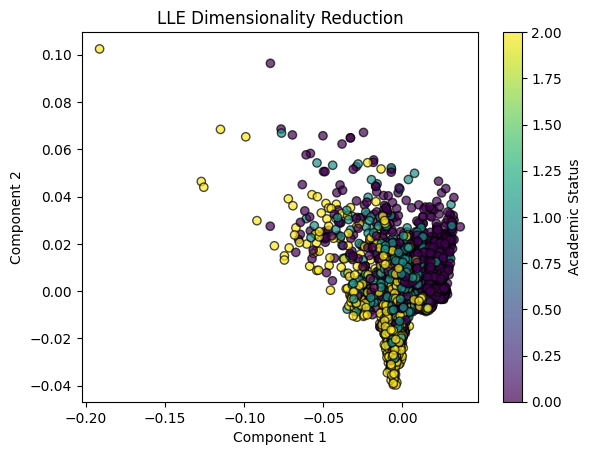

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

# LLE (n_components=11, fixed with PCA n_components)
lle = LocallyLinearEmbedding(n_components=11, n_neighbors=70, method='standard', random_state=42)
X_train_num_lle = lle.fit_transform(X_train[numeric_cols])
X_test_num_lle = lle.transform(X_test[numeric_cols])

# Visualize the LLE space
plt.scatter(X_train_num_lle[:, 0], X_train_num_lle[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(label="Academic Status")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("LLE Dimensionality Reduction")
plt.show()

The separation of classes in this space is not very defined. We can still try to proceed with the classification using the merged feature space.

In [32]:
# Merge the feature space
X_train_num_lle = pd.DataFrame(X_train_num_lle, columns=[f'LLE{i+1}' for i in range(X_train_num_lle.shape[1])])
X_train_lle = pd.concat([X_train_num_lle.reset_index(drop=True),
                        X_train[categ_cols].reset_index(drop=True)], axis=1)
X_test_num_lle = pd.DataFrame(X_test_num_lle, columns=[f'LLE{i+1}' for i in range(X_test_num_lle.shape[1])])
X_test_lle = pd.concat([X_test_num_lle.reset_index(drop=True),
                        X_test[categ_cols].reset_index(drop=True)], axis=1)

print(X_train.shape)
print(X_train_lle.shape)
print(X_test_lle.shape)

(4638, 210)
(4638, 206)
(1989, 206)


In [33]:
# Specify grid of hyperparameters
param_grid_3 = {
    "C": [0.01, 0.1, 1, 10, 100, 1000, 10000],
    "kernel": ["rbf"],   # Fix to rbf based on previous results
    "gamma": ["scale", "auto"]
}

grid7 = GridSearchCV(svc, param_grid_3, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start7 = time() 
grid7.fit(X_train_lle, y_train)
print("GridSearchCV took %.2f seconds." % (time() - start7))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
GridSearchCV took 72.33 seconds.


In [34]:
best_model_7 = grid7.best_estimator_
print("SVC + LLE")
print("Best Parameters:", grid7.best_params_)
print("Best Accuracy:", grid7.best_score_)

SVC + LLE
Best Parameters: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 0.744718316408139


In [35]:
# SVC-LLE-GridSearch - Accuracy and Confusion Matrix
print('SVC + LLE')
print(f"Accuracy = {best_model_7.score(X_test_lle, y_test)}")
print('Confusion Matrix')
y_test_pred_lle = best_model_7.predict(X_test_lle)
print(confusion_matrix(y_test, y_test_pred_lle))

# SVC-LLE-GridSearch - Classification Report
print(classification_report(y_test, y_test_pred_lle, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + LLE
Accuracy = 0.7516339869281046
Confusion Matrix
[[466 102  95]
 [ 77 455 131]
 [ 40  49 574]]
              precision    recall  f1-score   support

     Dropout       0.80      0.70      0.75       663
    Enrolled       0.75      0.69      0.72       663
    Graduate       0.72      0.87      0.78       663

    accuracy                           0.75      1989
   macro avg       0.76      0.75      0.75      1989
weighted avg       0.76      0.75      0.75      1989



Using LLE + SVC resulted in worse performance than all the other models discussed previously. This may suggest that the dataset may not be suitable to locally-linear embedding, and that simpler dimensionality reduction techniques may be better.

#### LLE + LogReg

In [36]:
grid8 = GridSearchCV(base_logreg, param_grid_2, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start8 = time() 
grid8.fit(X_train_lle, y_train)

print("GridSearchCV took %.2f seconds."
      % (time() - start8))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 8.03 seconds.


In [37]:
best_model_8 = grid8.best_estimator_
print("LR + LLE")
print("Best Parameters:", grid8.best_params_)
print("Best Accuracy:", grid8.best_score_)

LR + LLE
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy: 0.7669261243164825


In [38]:
# LR-LLE-GridSearch - Accuracy and Confusion Matrix
print('LR + LLE')
print(f"Accuracy = {best_model_8.score(X_test_lle, y_test)}")
print('Confusion Matrix')
y2_test_pred_lle = best_model_8.predict(X_test_lle)
print(confusion_matrix(y_test, y2_test_pred_lle))

# LR-LLE-GridSearch - Classification Report
print(classification_report(y_test, y2_test_pred_lle, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + LLE
Accuracy = 0.7631975867269984
Confusion Matrix
[[481 105  77]
 [ 92 444 127]
 [ 29  41 593]]
              precision    recall  f1-score   support

     Dropout       0.80      0.73      0.76       663
    Enrolled       0.75      0.67      0.71       663
    Graduate       0.74      0.89      0.81       663

    accuracy                           0.76      1989
   macro avg       0.77      0.76      0.76      1989
weighted avg       0.77      0.76      0.76      1989



LLE + LogReg performed slightly better than LLE + SVC. This is similar to the case where kernel PCA is used for dimensionalty reduction. Logistic regression models tend to perform better than SVC in this dataset where nonlinear dimensionality reduction techniques were applied.

#### UMAP (Numeric) + SVC

Uniform Manifold Approximation and Projection (UMAP) is a relatively new dimensionality reduction technique used to visualize high-dimensional data into 2D space (or higher), which preserves inherent structures in the dataset.

c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


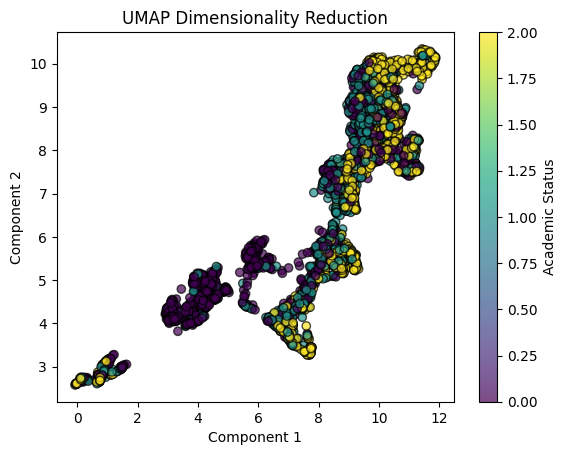

In [ ]:
import umap

# Use UMAP with n_components=11 (fixed with PCA n_components)
reducer = umap.UMAP(n_components=11, n_neighbors=50, min_dist=0.2, metric='euclidean', random_state=42)
X_train_num_umap = reducer.fit_transform(X_train[numeric_cols])
X_test_num_umap = reducer.transform(X_test[numeric_cols])

# Visualize the UMAP space
plt.scatter(X_train_num_umap[:, 0], X_train_num_umap[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(label="Academic Status")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP Dimensionality Reduction")
plt.show()

Similar to the previous dimensionality reduction models, the separation of classes in this dataset using UMAP is not very well-defined. We can see a large cluster containing points from all three classes. We can still try to proceed with SVC and LR model creation to perform classification on the reduced feature space.

In [40]:
# Merge the feature space
X_train_num_umap = pd.DataFrame(X_train_num_umap, columns=[f'UMAP{i+1}' for i in range(X_train_num_umap.shape[1])])
X_train_umap = pd.concat([X_train_num_umap.reset_index(drop=True),
                        X_train[categ_cols].reset_index(drop=True)], axis=1)
X_test_num_umap = pd.DataFrame(X_test_num_umap, columns=[f'UMAP{i+1}' for i in range(X_test_num_umap.shape[1])])
X_test_umap = pd.concat([X_test_num_umap.reset_index(drop=True),
                        X_test[categ_cols].reset_index(drop=True)], axis=1)

print(X_train.shape)
print(X_train_umap.shape)
print(X_test_umap.shape)

(4638, 210)
(4638, 206)
(1989, 206)


In [41]:
grid9 = GridSearchCV(svc, param_grid_3, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start9 = time() 
grid9.fit(X_train_umap, y_train)
print("GridSearchCV took %.2f seconds." % (time() - start9))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
GridSearchCV took 65.21 seconds.


In [42]:
best_model_9 = grid9.best_estimator_
print("SVC + UMAP")
print("Best Parameters:", grid9.best_params_)
print("Best Accuracy:", grid9.best_score_)

SVC + UMAP
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.7697301733437488


In [43]:
# SVC-UMAP-GridSearch - Accuracy and Confusion Matrix
print('SVC + UMAP')
print(f"Accuracy = {best_model_9.score(X_test_umap, y_test)}")
print('Confusion Matrix')
y_test_pred_umap = best_model_9.predict(X_test_umap)
print(confusion_matrix(y_test, y_test_pred_umap))

# SVC-UMAP-GridSearch - Classification Report
print(classification_report(y_test, y_test_pred_umap, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + UMAP
Accuracy = 0.7647058823529411
Confusion Matrix
[[450 113 100]
 [ 62 471 130]
 [ 26  37 600]]
              precision    recall  f1-score   support

     Dropout       0.84      0.68      0.75       663
    Enrolled       0.76      0.71      0.73       663
    Graduate       0.72      0.90      0.80       663

    accuracy                           0.76      1989
   macro avg       0.77      0.76      0.76      1989
weighted avg       0.77      0.76      0.76      1989



This yielded similar results to the LLE + SVC model, since they both use manifold learning for dimensionality reduction. This model performed slightly better than LLE + SVC, but still performs worse than SVC with PCA and LDA-transformed feature space.

#### UMAP (Numeric) + LogReg

In [44]:
grid10 = GridSearchCV(base_logreg, param_grid_2, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start10 = time() 
grid10.fit(X_train_umap, y_train)

print("GridSearchCV took %.2f seconds."
      % (time() - start10))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 19.72 seconds.


In [45]:
best_model_10 = grid10.best_estimator_
print("LR + UMAP")
print("Best Parameters:", grid10.best_params_)
print("Best Accuracy:", grid10.best_score_)

LR + UMAP
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy: 0.7466591340252204


In [46]:
# LR-UMAP-GridSearch - Accuracy and Confusion Matrix
print('LR + UMAP')
print(f"Accuracy = {best_model_10.score(X_test_umap, y_test)}")
print('Confusion Matrix')
y2_test_pred_umap = best_model_10.predict(X_test_umap)
print(confusion_matrix(y_test, y2_test_pred_umap))

# LR-UMAP-GridSearch - Classification Report
print(classification_report(y_test, y2_test_pred_umap, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + UMAP
Accuracy = 0.7425842131724485
Confusion Matrix
[[464 100  99]
 [ 82 443 138]
 [ 54  39 570]]
              precision    recall  f1-score   support

     Dropout       0.77      0.70      0.73       663
    Enrolled       0.76      0.67      0.71       663
    Graduate       0.71      0.86      0.78       663

    accuracy                           0.74      1989
   macro avg       0.75      0.74      0.74      1989
weighted avg       0.75      0.74      0.74      1989



This also performed similar to the LLE + LR model, but with slightly worse accuracy.

#### UMAP (All) + SVC

We can also try to transform the categorical feature space using UMAP with Hamming metric (for one-hot encoded features).

c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


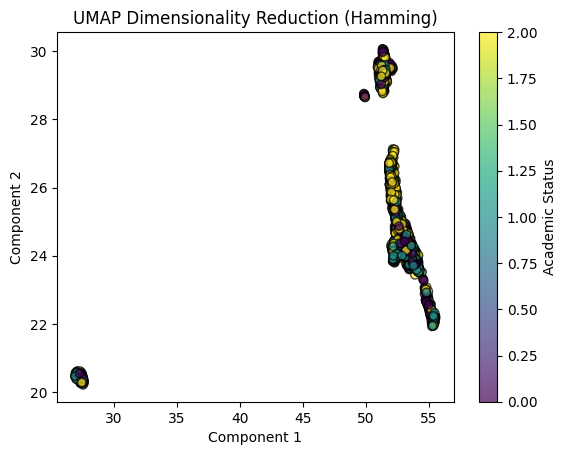

In [47]:
# Use UMAP for categorical features with n_components=10
reducer2 = umap.UMAP(n_components=10, n_neighbors=50, min_dist=0.20, metric='hamming', random_state=42)
X_train_cat_umap = reducer2.fit_transform(X_train[categ_cols])
X_test_cat_umap = reducer2.transform(X_test[categ_cols])

# Visualize the categorical UMAP space
plt.scatter(X_train_cat_umap[:, 0], X_train_cat_umap[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(label="Academic Status")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP Dimensionality Reduction (Hamming)")
plt.show()

The 2D visualization of the UMAP-reduced categorical feature space does not look very promising in terms of class separation. 

In [48]:
# Merge the feature space
X_train_cat_umap = pd.DataFrame(X_train_cat_umap, columns=[f'UMAP_cat{i+1}' for i in range(X_train_cat_umap.shape[1])])
X_train_umap2 = pd.concat([X_train_num_umap.reset_index(drop=True),
                        X_train_cat_umap.reset_index(drop=True)], axis=1)
X_test_cat_umap = pd.DataFrame(X_test_cat_umap, columns=[f'UMAP_cat{i+1}' for i in range(X_test_cat_umap.shape[1])])
X_test_umap2 = pd.concat([X_test_num_umap.reset_index(drop=True),
                        X_test_cat_umap.reset_index(drop=True)], axis=1)

print(X_train.shape)
print(X_train_umap2.shape)
print(X_test_umap2.shape)
display(X_train_umap2)

(4638, 210)
(4638, 21)
(1989, 21)


,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,UMAP11,UMAP_cat1,UMAP_cat2,UMAP_cat3,UMAP_cat4,UMAP_cat5,UMAP_cat6,UMAP_cat7,UMAP_cat8,UMAP_cat9,UMAP_cat10
0,0.741349,2.709054,4.291727,4.737021,7.485398,1.475260,6.573712,4.918847,5.287333,5.169065,3.356450,52.267181,23.941753,-19.527807,-26.034153,-35.067875,-3.301448,-50.240887,63.645817,34.788376,-9.277006
1,8.308406,5.772425,6.597653,4.030796,7.558217,0.160913,8.122216,4.478868,5.500543,6.316159,3.691969,53.430653,24.101051,-16.924421,-26.145987,-32.148323,-4.256960,-50.941788,65.995621,34.395710,-7.103809
2,11.208222,7.937291,5.204821,4.936131,8.159071,1.263462,6.402267,2.947646,5.391216,7.155828,3.450549,53.706753,23.810417,-17.029940,-25.310198,-32.154911,-4.556024,-50.632912,65.176682,33.127403,-6.831069
3,3.286267,4.366991,3.568466,3.167292,6.730079,1.026569,7.888340,4.892409,5.495284,5.438488,3.232377,51.372440,29.964388,-19.671309,-22.269770,-34.561275,-7.640605,-49.797771,54.272671,39.570282,-17.960989
4,10.116335,9.272555,7.626418,4.051379,8.046510,-1.799568,5.795401,2.276799,6.401298,4.524658,3.285094,52.315773,25.621264,-20.128759,-24.501926,-34.195457,-3.615936,-54.070744,63.691364,37.101063,-12.374299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4633,10.477291,9.644533,7.525048,4.297715,9.687057,-1.720715,6.977633,2.609497,6.156714,5.916245,3.353100,52.223671,25.637096,-19.937054,-24.924858,-34.353424,-3.308090,-53.744545,63.806076,36.432701,-11.644470
4634,9.684528,9.840383,7.853126,3.112587,7.557434,-1.696000,5.707631,2.329746,6.224357,5.021099,3.070320,51.858833,26.718206,-19.869791,-25.083525,-34.318329,-4.187863,-53.713268,63.827999,35.400043,-12.677495
4635,8.763757,5.268746,1.552989,4.703461,7.824568,0.330147,6.744599,3.563985,5.647927,5.961723,3.273804,27.449459,20.285496,-5.504705,-0.078099,-13.630385,-6.049332,-11.209846,19.315079,16.532457,-2.060515
4636,5.765908,5.664792,4.467439,3.488400,7.631129,0.601517,7.241325,4.081438,5.528215,5.918117,3.471180,53.076061,24.426447,-18.919907,-26.415907,-34.884861,-3.526515,-52.435024,64.141426,36.180706,-9.553978


In [49]:
grid11 = GridSearchCV(svc, param_grid_3, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start11 = time() 
grid11.fit(X_train_umap2, y_train)
print("GridSearchCV took %.2f seconds." % (time() - start11))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
GridSearchCV took 16.88 seconds.


In [50]:
best_model_11 = grid11.best_estimator_
print("SVC + UMAP (w/ Transformed Cat. Features)")
print("Best Parameters:", grid11.best_params_)
print("Best Accuracy:", grid11.best_score_)

SVC + UMAP (w/ Transformed Cat. Features)
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 0.7136705817803073


In [51]:
# SVC-UMAP-GridSearch - Accuracy and Confusion Matrix
print('SVC + UMAP (w/ Transformed Cat. Features)')
print(f"Accuracy = {best_model_11.score(X_test_umap2, y_test)}")
print('Confusion Matrix')
y_test_pred_umap2 = best_model_11.predict(X_test_umap2)
print(confusion_matrix(y_test, y_test_pred_umap2))

# SVC-UMAP-GridSearch - Classification Report
print(classification_report(y_test, y_test_pred_umap2, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + UMAP (w/ Transformed Cat. Features)
Accuracy = 0.6530920060331825
Confusion Matrix
[[389 197  77]
 [ 66 528  69]
 [ 32 249 382]]
              precision    recall  f1-score   support

     Dropout       0.80      0.59      0.68       663
    Enrolled       0.54      0.80      0.65       663
    Graduate       0.72      0.58      0.64       663

    accuracy                           0.65      1989
   macro avg       0.69      0.65      0.65      1989
weighted avg       0.69      0.65      0.65      1989



Since both categorical and numeric features were reduced, the performance obtained from this model is significantly worse compared to models discussed previously. However, the feature space of this model is only 21-dimensional, compared te the previous feature space with approximately 200 dimensions.

#### UMAP (All) + LogReg

In [52]:
grid12 = GridSearchCV(base_logreg, param_grid_2, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start12 = time() 
grid12.fit(X_train_umap2, y_train)

print("GridSearchCV took %.2f seconds."
      % (time() - start12))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 8.72 seconds.


c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\optimize.py:311: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


The logistic regression model trained on this feature space may have struggled finding the best hyperparameters using GridSearchCV.

In [53]:
best_model_12 = grid12.best_estimator_
print("LR + UMAP (w/ Transformed Cat. Features)")
print("Best Parameters:", grid12.best_params_)
print("Best Accuracy:", grid12.best_score_)

LR + UMAP (w/ Transformed Cat. Features)
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy: 0.6517971394561619


In [54]:
# LR-UMAP-GridSearch - Accuracy and Confusion Matrix
print('LR + UMAP (w/ Transformed Cat. Features)')
print(f"Accuracy = {best_model_12.score(X_test_umap2, y_test)}")
print('Confusion Matrix')
y2_test_pred_umap2 = best_model_12.predict(X_test_umap2)
print(confusion_matrix(y_test, y2_test_pred_umap2))

# LR-UMAP-GridSearch - Classification Report
print(classification_report(y_test, y2_test_pred_umap2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + UMAP (w/ Transformed Cat. Features)
Accuracy = 0.6153846153846154
Confusion Matrix
[[347 217  99]
 [ 65 500  98]
 [ 44 242 377]]
              precision    recall  f1-score   support

     Dropout       0.76      0.52      0.62       663
    Enrolled       0.52      0.75      0.62       663
    Graduate       0.66      0.57      0.61       663

    accuracy                           0.62      1989
   macro avg       0.65      0.62      0.62      1989
weighted avg       0.65      0.62      0.62      1989



As expected, the LR model also performed worse on this feature space.

## Summary of Model Evaluation Results

### Principal Component Analysis

In [55]:
# SVC-PCA-GridSearch
print('SVC + PCA')
print(f"Accuracy = {best_model_1.score(X_test_pca, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_pred_pca))
print(classification_report(y_test, y_test_pred_pca, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + PCA
Accuracy = 0.7883358471593765
Confusion Matrix
[[485 108  70]
 [ 69 492 102]
 [ 24  48 591]]
              precision    recall  f1-score   support

     Dropout       0.84      0.73      0.78       663
    Enrolled       0.76      0.74      0.75       663
    Graduate       0.77      0.89      0.83       663

    accuracy                           0.79      1989
   macro avg       0.79      0.79      0.79      1989
weighted avg       0.79      0.79      0.79      1989



In [56]:
# LR-PCA-GridSearch
print('LR + PCA')
print(f"Accuracy = {best_model_2.score(X_test_pca, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y2_test_pred_pca))
print(classification_report(y_test, y2_test_pred_pca, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + PCA
Accuracy = 0.7616892911010558
Confusion Matrix
[[486 110  67]
 [102 463  98]
 [ 41  56 566]]
              precision    recall  f1-score   support

     Dropout       0.77      0.73      0.75       663
    Enrolled       0.74      0.70      0.72       663
    Graduate       0.77      0.85      0.81       663

    accuracy                           0.76      1989
   macro avg       0.76      0.76      0.76      1989
weighted avg       0.76      0.76      0.76      1989



### Linear Discriminant Analysis

In [57]:
# SVC-LDA-GridSearch
print('SVC + LDA')
print(f"Accuracy = {best_model_3.score(X_test_lda, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_pred_lda))
print(classification_report(y_test, y_test_pred_lda, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + LDA
Accuracy = 0.7908496732026143
Confusion Matrix
[[505  88  70]
 [ 84 464 115]
 [ 16  43 604]]
              precision    recall  f1-score   support

     Dropout       0.83      0.76      0.80       663
    Enrolled       0.78      0.70      0.74       663
    Graduate       0.77      0.91      0.83       663

    accuracy                           0.79      1989
   macro avg       0.79      0.79      0.79      1989
weighted avg       0.79      0.79      0.79      1989



In [58]:
# LR-LDA-GridSearch
print('LR + LDA')
print(f"Accuracy = {best_model_4.score(X_test_lda, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y2_test_pred_lda))
print(classification_report(y_test, y2_test_pred_lda, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + LDA
Accuracy = 0.7807943690296631
Confusion Matrix
[[499 105  59]
 [ 86 469 108]
 [ 30  48 585]]
              precision    recall  f1-score   support

     Dropout       0.81      0.75      0.78       663
    Enrolled       0.75      0.71      0.73       663
    Graduate       0.78      0.88      0.83       663

    accuracy                           0.78      1989
   macro avg       0.78      0.78      0.78      1989
weighted avg       0.78      0.78      0.78      1989



### Kernel PCA

In [59]:
# SVC-KPCA-GridSearch - Accuracy and Confusion Matrix
print('SVC + KPCA')
print(f"Accuracy = {best_model_5.score(X_test_kpca, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_pred_kpca))
print(classification_report(y_test, y_test_pred_kpca, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + KPCA
Accuracy = 0.7682252388134742
Confusion Matrix
[[471 108  84]
 [ 86 463 114]
 [ 27  42 594]]
              precision    recall  f1-score   support

     Dropout       0.81      0.71      0.76       663
    Enrolled       0.76      0.70      0.73       663
    Graduate       0.75      0.90      0.82       663

    accuracy                           0.77      1989
   macro avg       0.77      0.77      0.77      1989
weighted avg       0.77      0.77      0.77      1989



In [60]:
# LR-KPCA-GridSearch - Accuracy and Confusion Matrix
print('LR + KPCA')
print(f"Accuracy = {best_model_6.score(X_test_kpca, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y2_test_pred_kpca))
print(classification_report(y_test, y2_test_pred_kpca, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + KPCA
Accuracy = 0.7652086475615887
Confusion Matrix
[[468 110  85]
 [ 83 466 114]
 [ 37  38 588]]
              precision    recall  f1-score   support

     Dropout       0.80      0.71      0.75       663
    Enrolled       0.76      0.70      0.73       663
    Graduate       0.75      0.89      0.81       663

    accuracy                           0.77      1989
   macro avg       0.77      0.77      0.76      1989
weighted avg       0.77      0.77      0.76      1989



### Locally-Linear Embeddings

In [61]:
# SVC-LLE-GridSearch - Accuracy and Confusion Matrix
print('SVC + LLE')
print(f"Accuracy = {best_model_7.score(X_test_lle, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_pred_lle))
print(classification_report(y_test, y_test_pred_lle, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + LLE
Accuracy = 0.7516339869281046
Confusion Matrix
[[466 102  95]
 [ 77 455 131]
 [ 40  49 574]]
              precision    recall  f1-score   support

     Dropout       0.80      0.70      0.75       663
    Enrolled       0.75      0.69      0.72       663
    Graduate       0.72      0.87      0.78       663

    accuracy                           0.75      1989
   macro avg       0.76      0.75      0.75      1989
weighted avg       0.76      0.75      0.75      1989



In [62]:
# LR-LLE-GridSearch - Accuracy and Confusion Matrix
print('LR + LLE')
print(f"Accuracy = {best_model_8.score(X_test_lle, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y2_test_pred_lle))
print(classification_report(y_test, y2_test_pred_lle, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + LLE
Accuracy = 0.7631975867269984
Confusion Matrix
[[481 105  77]
 [ 92 444 127]
 [ 29  41 593]]
              precision    recall  f1-score   support

     Dropout       0.80      0.73      0.76       663
    Enrolled       0.75      0.67      0.71       663
    Graduate       0.74      0.89      0.81       663

    accuracy                           0.76      1989
   macro avg       0.77      0.76      0.76      1989
weighted avg       0.77      0.76      0.76      1989



### UMAP (Numeric Features)

In [63]:
# SVC-UMAP-GridSearch - Accuracy and Confusion Matrix
print('SVC + UMAP')
print(f"Accuracy = {best_model_9.score(X_test_umap, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_pred_umap))
print(classification_report(y_test, y_test_pred_umap, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + UMAP
Accuracy = 0.7647058823529411
Confusion Matrix
[[450 113 100]
 [ 62 471 130]
 [ 26  37 600]]
              precision    recall  f1-score   support

     Dropout       0.84      0.68      0.75       663
    Enrolled       0.76      0.71      0.73       663
    Graduate       0.72      0.90      0.80       663

    accuracy                           0.76      1989
   macro avg       0.77      0.76      0.76      1989
weighted avg       0.77      0.76      0.76      1989



In [64]:
# LR-UMAP-GridSearch - Accuracy and Confusion Matrix
print('LR + UMAP')
print(f"Accuracy = {best_model_10.score(X_test_umap, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y2_test_pred_umap))
print(classification_report(y_test, y2_test_pred_umap, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + UMAP
Accuracy = 0.7425842131724485
Confusion Matrix
[[464 100  99]
 [ 82 443 138]
 [ 54  39 570]]
              precision    recall  f1-score   support

     Dropout       0.77      0.70      0.73       663
    Enrolled       0.76      0.67      0.71       663
    Graduate       0.71      0.86      0.78       663

    accuracy                           0.74      1989
   macro avg       0.75      0.74      0.74      1989
weighted avg       0.75      0.74      0.74      1989



### UMAP (Numeric + Categorical Features)

In [65]:
# SVC-UMAP-GridSearch - Accuracy and Confusion Matrix
print('SVC + UMAP (w/ Transformed Cat. Features)')
print(f"Accuracy = {best_model_11.score(X_test_umap2, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_pred_umap2))
print(classification_report(y_test, y_test_pred_umap2, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + UMAP (w/ Transformed Cat. Features)
Accuracy = 0.6530920060331825
Confusion Matrix
[[389 197  77]
 [ 66 528  69]
 [ 32 249 382]]
              precision    recall  f1-score   support

     Dropout       0.80      0.59      0.68       663
    Enrolled       0.54      0.80      0.65       663
    Graduate       0.72      0.58      0.64       663

    accuracy                           0.65      1989
   macro avg       0.69      0.65      0.65      1989
weighted avg       0.69      0.65      0.65      1989



In [66]:
# LR-UMAP-GridSearch - Accuracy and Confusion Matrix
print('LR + UMAP (w/ Transformed Cat. Features)')
print(f"Accuracy = {best_model_12.score(X_test_umap2, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, y2_test_pred_umap2))
print(classification_report(y_test, y2_test_pred_umap2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + UMAP (w/ Transformed Cat. Features)
Accuracy = 0.6153846153846154
Confusion Matrix
[[347 217  99]
 [ 65 500  98]
 [ 44 242 377]]
              precision    recall  f1-score   support

     Dropout       0.76      0.52      0.62       663
    Enrolled       0.52      0.75      0.62       663
    Graduate       0.66      0.57      0.61       663

    accuracy                           0.62      1989
   macro avg       0.65      0.62      0.62      1989
weighted avg       0.65      0.62      0.62      1989



Overall best performing model: **LDA (Numeric Features) + Support Vector Classifier**

Overall worst performing model: **UMAP (Num. + Cat. Features) + Logistic Regression**